In [1]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys

import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sams
import holodeck.gravwaves
from holodeck import cosmo, utils, plot, discrete, sams, host_relations, _PATH_DATA
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC
from pathlib import Path

import compare_discrete

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.INFO)

# ---- Define filepath containing simulation galaxy merger data files ----#
# ---- (if using files not in _PATH_DATA) ---- #
_HOME_PATH = Path('~/').expanduser()
p = os.path.join(_HOME_PATH, 'cosmo_sim_merger_data')
if os.path.exists(p):
    _SIM_MERGER_PATH = p
else:
    p = os.path.join(_HOME_PATH, 'nanograv/cosmo_sim_merger_data')
    if os.path.exists(p):
        _SIM_MERGER_PATH = p
    else:
        _SIM_MERGER_PATH = _PATH_DATA
# ------------------------------------------------------------------------ #

In [18]:
def calc_sim_merging_bhmf(dpop, mass_type='all', req_z=None, req_dz=None, mask=None, verbose=False):

    assert isinstance(dpop, compare_discrete.Discrete), '`dpop` must be an instance of the `Discrete` class'

    mbh = dpop.pop.mass / MSOL 
    if verbose: print(f"in calc_bhmf: {mbh.shape=}")

    if req_z is None:
        if verbose: print("calculating BHMF for all redshifts.")
        if mask is not None:
            mbh = mbh[mask]
    else:
        if req_dz is None:
            req_dz = 0.1
        z = dpop.pop.redz
        zmask = (np.abs(z-req_z)<req_dz)
        if mask is not None:
            mbh = mbh[mask&zmask]
        else:
            mbh = mbh[zmask]
    print(f"after masking, in calc_sim_merging_bhmf: {mbh.shape=}")
  
    if mass_type == 'tot':
        mbh = mbh[:,0] + mbh[:,1]
        if verbose: print(f"{mbh.min()=}, {mbh.max()=}, {mbh.mean()=}, , {mbh.shape=}")
    elif mass_type == 'pri':
        mbh = mbh.max(axis = 1)
        if verbose: print(f"{mbh.min()=}, {mbh.max()=}, {mbh.mean()=}, , {mbh.shape=}")
    elif mass_type not in ('tot','pri','all'):
        err = "`mass_type` must be 'tot', 'pri', or 'all'"
        raise ValueError(err)

    if verbose: print(f"after setting mass_type, in calc_sim_merging_bhmf: {data.shape=}")

    mbh = np.log10(mbh)
    box_vol_mpc = dpop.pop._sample_volume / (1.0e6*PC)**3
    if verbose: print(f"{box_vol_mpc=}")    

    mhist, mbin_edges = np.histogram(mbh, range=(4.25,12.25), bins=16) #bins=mbins)
    mbinsize = mbin_edges[1]-mbin_edges[0]
    mbins = mbin_edges[:-1]+mbinsize
        

    return mbins, mhist / mbinsize / box_vol_mpc, mhist

def compare_sim_merging_bhmfs(dpops, req_z=None, req_dz=None):
    
    assert isinstance(dpops, list), '`dpops` must be a list of discrete populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    ax.set(xlabel=r'$\log_{10}(M_{tot})$')
    ax.set(ylabel=r'BHMF [$(dex^{-1} Mpc^{-3}$]')

    if req_z is None:
        lbl_extra = ' (mergers, all z)'
    else:
        lbl_extra = f' (mergers, {np.maximum(0,req_z-req_dz):.2g}<z<{req_z+req_dz:.2g})'
 
    for i,dp in enumerate(dpops):
        
        mbins, bhmf, mhist = calc_sim_merging_bhmf(dp, req_z=req_z, req_dz=req_dz)
        
        #ax.plot(mbins, bhmf, color=dp.color, lw=dp.lw, label=dp.lbl)

        plt.plot(mbins, bhmf, ':', alpha=0.5, color=dp.color, lw=dp.lw)
        plt.plot(mbins[mhist>10], bhmf[mhist>10], color=dp.color, lw=dp.lw,label=dp.lbl+lbl_extra)

    return fig, ax

Setting inspiral timescale tau = 1.0 Gyr.
Setting fixed init binary sep = 10000.0 pc.

Creating Discrete_Pop class instance 'Ill-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /Users/lblecha/cosmo_sim_merger_data/galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5
DEBUG: in population: self.scafa.min()=0.11634526, self.scafa.max()=1.0, np.median(self.scafa)=0.38398999
num with scafa=1: 25
gal_rads.min()=5.604741383306071e+21, gal_rads.max()=3.991318302684769e+23
self.sepa.min()=2.9670998035624385e+22, self.sepa.max()=4.588829976829252e+23
No zero-mass BHs found in this merger tree file!
self._use_mstar_tot_as_mbulge=False
self.mbulge.min()=4.097688561565048e+40, self.mbulge.max()=3.9210523650238056e+45
self.mstar_tot.min()=5.284912473673256e+40, self.mstar_tot.max()=5.84291502322986e+45
No zero-mass BHs found in this merger tree file!
18:06:47 WARNING : Redefining mass ratio to be always <= 1. [populatio

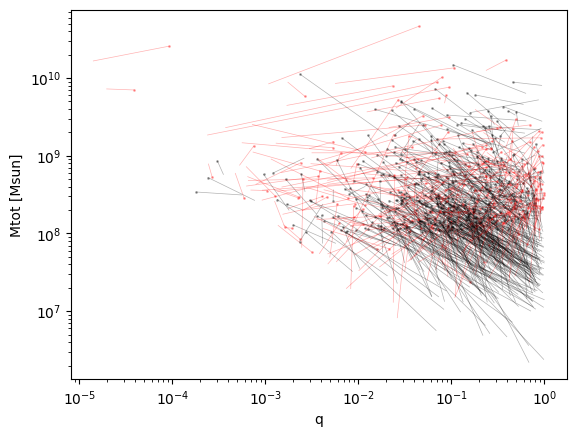

Ill-1 dpop_attrs: galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5 /Users/lblecha/cosmo_sim_merger_data g 2.5

Creating Discrete_Pop class instance 'TNG50-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5
fname = /Users/lblecha/cosmo_sim_merger_data/galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5
DEBUG: in population: self.scafa.min()=0.166779702, self.scafa.max()=1.0, np.median(self.scafa)=0.414233353
num with scafa=1: 1
gal_rads.min()=1.0893108283943573e+21, gal_rads.max()=1.3320659272107923e+23
self.sepa.min()=7.773575910247417e+21, self.sepa.max()=1.4396644441866531e+23
No zero-mass BHs found in this merger tree file!
self._use_mstar_tot_as_mbulge=False
self.mbulge.min()=9.186221157629952e+40, self.mbulge.max()=7.878625435370751e+44
self.mstar_tot.min()=1.0977431828768059e+41, self.mstar_tot.max()=1.5689466847415648e+45
No zero-mass BHs found in this merger tree file!
sample volume = 4.052e+78 [cgs] =

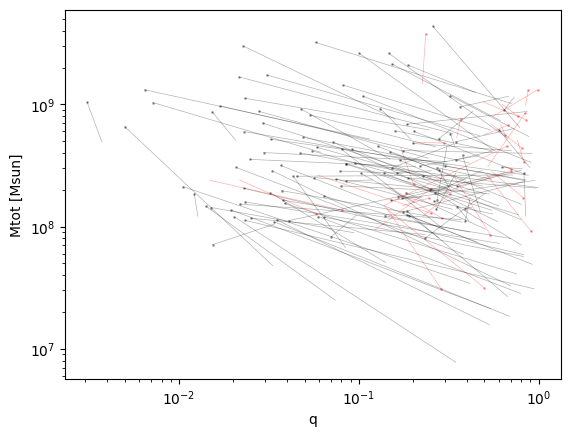

TNG50-1 dpop_attrs: galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5 /Users/lblecha/cosmo_sim_merger_data r 3.5

Creating Discrete_Pop class instance 'TNG100-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /Users/lblecha/cosmo_sim_merger_data/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
DEBUG: in population: self.scafa.min()=0.116345263, self.scafa.max()=1.0, np.median(self.scafa)=0.374999594
num with scafa=1: 11
gal_rads.min()=1.326763564100145e+21, gal_rads.max()=7.282709693743754e+23
self.sepa.min()=1.1155196797741347e+22, self.sepa.max()=7.917283537437711e+23
No zero-mass BHs found in this merger tree file!
self._use_mstar_tot_as_mbulge=False
self.mbulge.min()=1.3306179568569139e+41, self.mbulge.max()=2.5837386273508947e+45
self.mstar_tot.min()=2.2618726543725402e+41, self.mstar_tot.max()=3.765812268004308e+45
No zero-mass BHs found in this merger tree file!
18:06:48 WARNING : Redefining ma

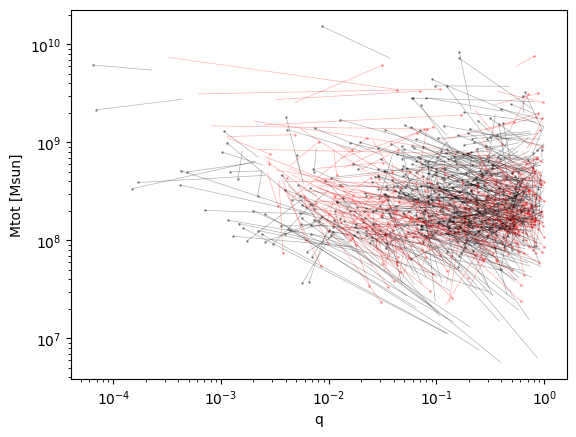

TNG100-1 dpop_attrs: galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5 /Users/lblecha/cosmo_sim_merger_data b 2.5

Creating Discrete_Pop class instance 'TNG300-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
fname = /Users/lblecha/cosmo_sim_merger_data/galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
DEBUG: in population: self.scafa.min()=0.105825971, self.scafa.max()=1.0, np.median(self.scafa)=0.374999594
num with scafa=1: 223
gal_rads.min()=2.2548351271477578e+21, gal_rads.max()=1.8838727682990497e+24
self.sepa.min()=1.452890195373455e+22, self.sepa.max()=1.9669581888711236e+24
No zero-mass BHs found in this merger tree file!
self._use_mstar_tot_as_mbulge=False
self.mbulge.min()=7.980400024699713e+40, self.mbulge.max()=7.55650715685173e+45
self.mstar_tot.min()=1.4264158438858985e+41, self.mstar_tot.max()=1.1136114523670047e+46
No zero-mass BHs found in this merger tree file!
sample volume = 8.143e+80 [cg

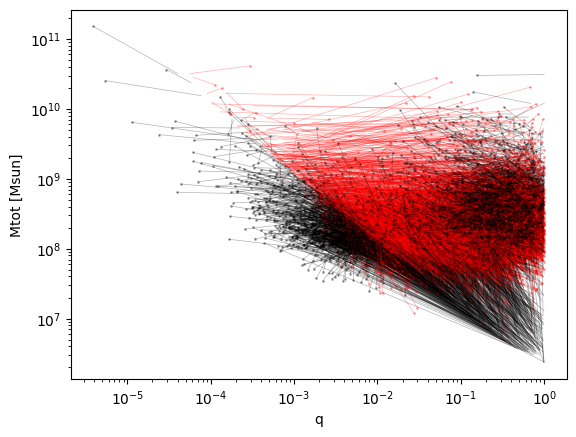

TNG300-1 dpop_attrs: galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5 /Users/lblecha/cosmo_sim_merger_data m 1.5


In [16]:
tmp = compare_discrete.create_dpops(allow_mbh0=True, mod_mmbulge=True, skip_evo=True, fpath=_SIM_MERGER_PATH)
all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops = tmp

In [4]:
print("creating SAM using Galaxy Pair Fraction (GPF) + Galaxy Merger Timescale (GMT)...")

sam = sams.Semi_Analytic_Model(gpf = sams.GPF_Power_Law())

print("SKIPPING HARDENING")

#print("    ...calculating hardening")
#hard = holo.hardening.Fixed_Time_2PL_SAM(sam, all_fsa_dpops[0].tau, sepa_init=1.0e4*PC)
#print("    ...creating gwb")
#gwb_sam = sam.gwb_new(all_fsa_dpops[0].freqs_edges, hard, realize=500)

creating SAM using Galaxy Pair Fraction (GPF) + Galaxy Merger Timescale (GMT)...
15:36:51 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
SKIPPING HARDENING


In [5]:
print("creating 'no-GPF' SAM using Galaxy Merger Rate (GMR) "
      "    (uses galaxy merger rates directly from RG15 instead of GPF+GMT)...")

sam_no_gpf = sams.Semi_Analytic_Model()

print("SKIPPING HARDENING")

#print("    ...calculating hardening for no-GPF SAM")
#hard_no_gpf = holo.hardening.Fixed_Time_2PL_SAM(sam_no_gpf, all_fsa_dpops[0].tau, sepa_init=1.0e4*PC)
#print("    ...creating gwb for no-GPF SAM")
#gwb_sam_no_gpf = sam_no_gpf.gwb_new(all_fsa_dpops[0].freqs_edges, hard_no_gpf, realize=50)

creating 'no-GPF' SAM using Galaxy Merger Rate (GMR)     (uses galaxy merger rates directly from RG15 instead of GPF+GMT)...
15:36:51 INFO : No galaxy pair-fraction given, using galaxy merger-rate. [sam.py:__init__]
SKIPPING HARDENING


after masking, in calc_sim_merging_bhmf: mbh.shape=(4279, 2)
after masking, in calc_sim_merging_bhmf: mbh.shape=(441, 2)
after masking, in calc_sim_merging_bhmf: mbh.shape=(3284, 2)
after masking, in calc_sim_merging_bhmf: mbh.shape=(61540, 2)


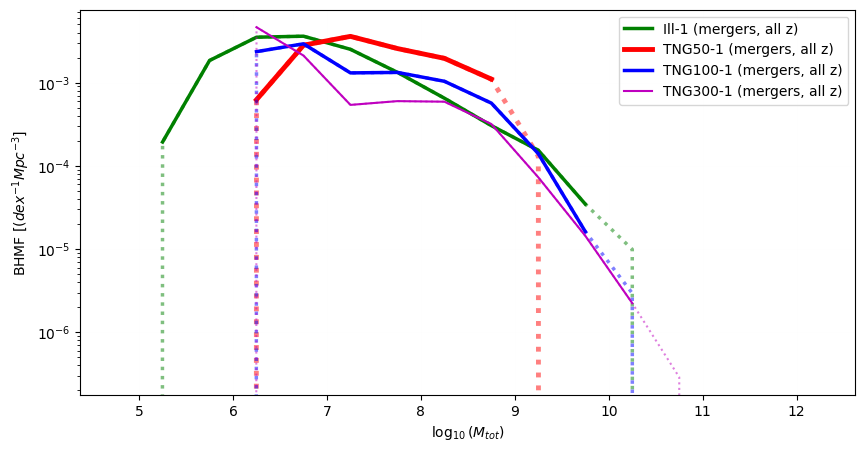

In [19]:
compare_sim_merging_bhmfs(all_dpops)
plt.legend()
plt.show()

after masking, in calc_sim_merging_bhmf: mbh.shape=(4279, 2)
after masking, in calc_sim_merging_bhmf: mbh.shape=(441, 2)
after masking, in calc_sim_merging_bhmf: mbh.shape=(3284, 2)
after masking, in calc_sim_merging_bhmf: mbh.shape=(61540, 2)


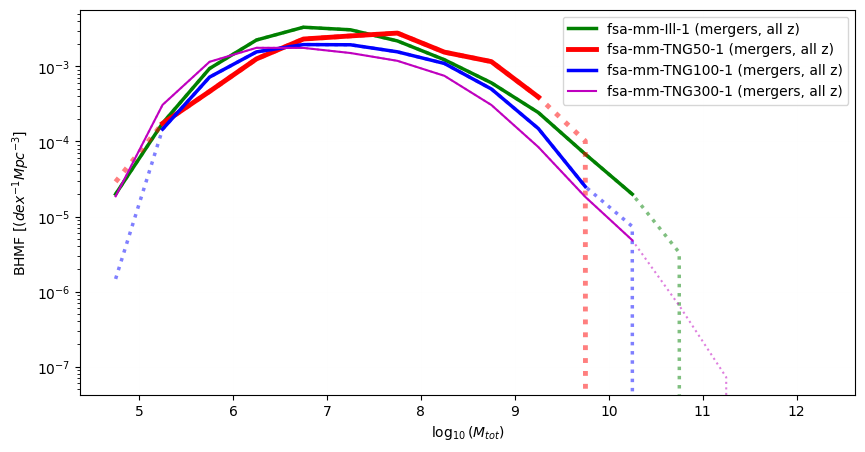

In [23]:
compare_sim_merging_bhmfs(all_fsa_dpops)
plt.legend()
plt.show()

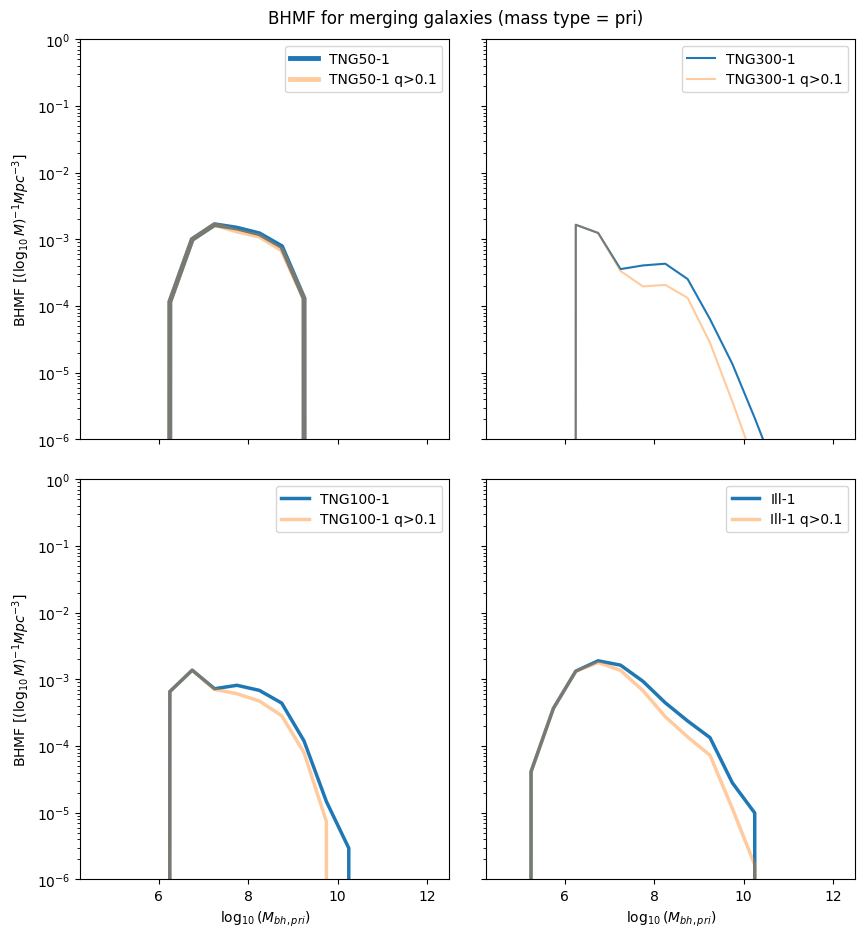

In [24]:
nrows = 2
ncols = 2
mass_type = 'pri'

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', sharey='all', figsize=[10,10])
#print(axes.shape)
#print(axes.dtype)
#print(axes[0].shape)

if mass_type == 'pri':
    xlab = r'$\log_{10}(M_{bh,pri})$'
elif mass_type == 'tot':
    xlab = r'$\log_{10}(M_{bh,tot})$'
elif mass_type == 'all':
    xlab = r'$\log_{10}(M_{bh}) (all progenitors)$'

axes[0,0].set(yscale='log', 
              ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(4.25,12.5), ylim=(1.0e-6,1.0))
axes[1,0].set(yscale='log',xlabel=xlab,
              ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(4.25,12.5), ylim=(1.0e-6,1.0))
axes[1,1].set(yscale='log',xlabel=xlab,
              #ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(4.25,12.5), ylim=(1.0e-6,1.0))
    
#dpop_lists = [t50_hires_fid_and_fsa_dpops, t100_hires_fid_and_fsa_dpops, ill_hires_fid_and_fsa_dpops]
dpop_lists = [ 
    [ d for d in all_dpops+all_fsa_dpops if d.lbl in ['TNG50-1', 'fsa-TNG50-1', 'fsa-TNG50-1-bh0'] ],
    #[ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG50-1-N100', 'fsa-TNG50-1-N100', 'fsa-TNG50-1-N100-bh0'] ],
    [ d for d in all_dpops+all_fsa_dpops if d.lbl in ['TNG100-1', 'fsa-TNG100-1', 'fsa-TNG100-1-bh0'] ],
    [ d for d in all_dpops+all_fsa_dpops if d.lbl in ['TNG300-1', 'fsa-TNG300-1', 'fsa-TNG300-1-bh0'] ],
    [ d for d in all_dpops+all_fsa_dpops if d.lbl in ['Ill-1', 'fsa-Ill-1', 'fsa-Ill-1-bh0'] ],
    #ill_hires_fid_and_fsa_dpops
    ]

for i in range(nrows):
    for j in range(ncols):
        
        if i+2*j >= (nrows*ncols): 
            break

        for dp in dpop_lists[i+2*j]:
            mtotbh, qbh = utils.mtmr_from_m1m2(dp.pop.mass)
            #print(f"{qbh.min()=} {qbh.max()=}")
            
            x,y = calc_bhmf(dp, mass_type=mass_type)
            axes[i,j].plot(x,y, lw=dp.lw, label=dp.lbl)
            
            xqcut,yqcut = calc_bhmf(dp, mask = (qbh>0.1), mass_type=mass_type)
            axes[i,j].plot(xqcut, yqcut, lw=dp.lw, label=dp.lbl+' q>0.1', alpha=0.4)

            axes[i,j].legend()

    else:
        continue  # only executed if the inner loop did NOT break
    break  # only executed if the inner loop DID break

fig.suptitle(f"BHMF for merging galaxies (mass type = {mass_type})")
fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)
plt.show()